## Preparation

In [ ]:
!pip install networkx scipy
!pip install plotly
!pip install pyvis
!pip install scikit-learn scipy seaborn
!pip install -U kaleido
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-bio
!pip install qiime2
!pip install qiime2-plugin-diversity


## Change the path

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

INPUT_FILE = "/home/marcos/PRJEB59406/master_table_mag_sialidase.tsv"
OUTPUT_DIR = "/home/marcos/PRJEB59406/figures"

try:
    df = pd.read_table(INPUT_FILE)
    print("Table loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: not found {INPUT_FILE}. Please check the file path.")


Table loaded successfully.


In [ ]:

ABUNDANCE_FILE = "/home/marcos/PRJEB59406/compactados/abundance_results/unified_abundance_with_groups.tsv"

import os
OUTPUT_DIR = "imagens"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)


## Heatmap

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

INPUT_FILE = "/home/marcos/PRJEB59406/results/Final_Table_Taxonomy_Function.tsv"
OUTPUT_DIR = "/home/marcos/PRJEB59406/figures/"
TOP_N_TAXA = 50 
DESIRED_ORDER = ["Control", "Atopic_dermatitis_non_lesion", "Atopic_dermatitis_lesion"]

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Loading data from: {INPUT_FILE}")
df = pd.read_csv(INPUT_FILE, sep='\t')

df['Label'] = df.apply(lambda x: x['Species'] if pd.notna(x['Species']) and len(str(x['Species'])) > 3 else f"{x['Genus']} ({x['mag_id']})", axis=1)

# Group Aggregation (Mean)
grouped_df = df.groupby(['Label', 'Group'])['Abundance'].mean().reset_index()
matrix = grouped_df.pivot(index='Label', columns='Group', values='Abundance').fillna(0)

# Ordering
available_groups = [g for g in DESIRED_ORDER if g in matrix.columns]
matrix = matrix[available_groups]

# Filtering Top N
top_taxa = matrix.sum(axis=1).nlargest(TOP_N_TAXA).index
matrix_filtered = matrix.loc[top_taxa]

# Normalization
matrix_log = np.log1p(matrix_filtered)

fig_height = max(8, len(matrix_log) * 0.25)
fig_width = 6 

g = sns.clustermap(
    matrix_log,
    cmap="magma_r",       
    method='ward',        
    metric='euclidean',   
    figsize=(fig_width, fig_height),
    
    col_cluster=False,    
    row_cluster=True,     
    
    dendrogram_ratio=(0.15, 0.01),
    cbar_pos=(0.05, 0.85, 0.03, 0.10), 
    yticklabels=True,     
    xticklabels=True      
)

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=10, rotation=45, ha='right')

g.fig.suptitle("Mean Sialidase Abundance per Group", y=1, fontsize=14)
g.ax_heatmap.set_ylabel("Microorganism", fontsize=12)
g.ax_heatmap.set_xlabel("", fontsize=12)

g.ax_cbar.set_ylabel("Mean Log(Abundance+1)", size=10)
g.ax_cbar.yaxis.set_label_position('left')
g.ax_cbar.yaxis.set_ticks_position('left')

outfile = os.path.join(OUTPUT_DIR, "heatmap_sialidase_grouped_mean.png")
plt.savefig(outfile, dpi=300, bbox_inches='tight')

print(f"\n Grouped Heatmap saved to: {outfile}")

## Co-occurrence Network 

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.lines import Line2D

INPUT_FILE = "/home/marcos/PRJEB59406/results/Final_Table_Taxonomy_Function.tsv"
OUTPUT_DIR = "/home/marcos/PRJEB59406/figures/"

# Analysis Settings
CORRELATION_THRESHOLD = 0.6   # Minimum correlation to draw a line
MIN_SAMPLE_PERCENTAGE = 0.15  # Bacteria must appear in at least 15% of samples
REPULSION_FORCE = 0.9         # "k" value: Higher = nodes push apart more
MARGIN_PADDING = 0.15         # 15% margin to prevent cutting off nodes

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    print(f"Loading data from: {INPUT_FILE}")
    df = pd.read_csv(INPUT_FILE, sep='\t')
    
    # Create Label: Use Species if available, otherwise Genus + ID
    df['Label'] = df.apply(lambda x: x['Species'] if pd.notna(x['Species']) and len(str(x['Species'])) > 3 else f"{x['Genus']} ({x['mag_id']})", axis=1)

    # Identify Groups
    if 'Group' not in df.columns: raise ValueError("Column 'Group' is missing.")
    
    # --- ORDER CONFIGURATION CHANGED HERE ---
    # Define your preferred order
    desired_order = ["Control", "Atopic_dermatitis_non_lesion", "Atopic_dermatitis_lesion"]
    
    # Get groups actually present in the file
    available_groups = set(df['Group'].unique())
    
    # Create the final list: 
    # 1. Take groups from desired_order IF they exist in the file
    unique_groups = [g for g in desired_order if g in available_groups]
    
    # 2. Append any other groups found in the file that were not in your list (safety fallback)
    remaining = [g for g in available_groups if g not in unique_groups]
    unique_groups.extend(sorted(remaining))
    
    n_groups = len(unique_groups)
    print(f"Plotting order: {unique_groups}")
    # ----------------------------------------
    
    # Define Colors for Phyla
    unique_phyla = df['Phylum'].unique()
    palette = sns.color_palette("tab10", len(unique_phyla))
    phylum_color_map = dict(zip(unique_phyla, palette))

    fig, axes = plt.subplots(1, n_groups, figsize=(8 * n_groups, 10))
    if n_groups == 1: axes = [axes]

    for i, group in enumerate(unique_groups):
        ax = axes[i]
        print(f"Processing Group: {group}...")

        # --- A. Prepare Matrix ---
        df_group = df[df['Group'] == group]
        df_grouped = df_group.groupby(['Label', 'Sample'])['Abundance'].sum().reset_index()
        matrix = df_grouped.pivot(index='Label', columns='Sample', values='Abundance').fillna(0)
        
        # Filter: Remove rare bacteria (present in < 15% of samples)
        min_samples = max(2, matrix.shape[1] * MIN_SAMPLE_PERCENTAGE) 
        matrix = matrix[matrix.astype(bool).sum(axis=1) >= min_samples]

        # Check if enough data remains
        if matrix.empty or matrix.shape[1] < 3:
            ax.text(0.5, 0.5, "Insufficient Data\n(Few samples/bacteria)", ha='center')
            ax.set_title(group)
            continue

        # --- B. Correlation & Graph Construction ---
        # Calculate Spearman correlation
        cor_matrix = matrix.T.corr(method='spearman').fillna(0)
        G = nx.Graph()
        
        # Add Nodes (Bacteria)
        for taxon in cor_matrix.columns:
            match = df[df['Label'] == taxon]
            if not match.empty:
                phylum = match['Phylum'].iloc[0]
                avg_abund = matrix.loc[taxon].mean()
                G.add_node(taxon, phylum=phylum, size=avg_abund, color=phylum_color_map.get(phylum, 'grey'))

        # Add Edges (Connections) based on threshold
        for u in range(len(cor_matrix.columns)):
            for v in range(u + 1, len(cor_matrix.columns)):
                weight = cor_matrix.iloc[u, v]
                if weight > CORRELATION_THRESHOLD:
                    G.add_edge(cor_matrix.columns[u], cor_matrix.columns[v], weight=weight)
        
        # Remove isolated nodes (no connections)
        G.remove_nodes_from(list(nx.isolates(G)))

        # --- C. Layout & Drawing ---
        if G.number_of_nodes() > 0:
            # Force-directed layout
            pos = nx.spring_layout(G, k=REPULSION_FORCE, iterations=50, seed=42)
            
            # Extract attributes
            node_colors = [nx.get_node_attributes(G, 'color')[n] for n in G.nodes]
            node_sizes = [np.log1p(nx.get_node_attributes(G, 'size')[n]) * 300 for n in G.nodes]
            
            # Draw
            nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax, alpha=0.9, edgecolors='white')
            nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.2, width=1)
            nx.draw_networkx_labels(G, pos, ax=ax, font_size=6, font_weight='bold')

            # --- D. Prevent Cut-off (Margin Fix) ---
            all_x = [coords[0] for coords in pos.values()]
            all_y = [coords[1] for coords in pos.values()]
            
            if all_x and all_y:
                x_span = max(all_x) - min(all_x) or 1
                y_span = max(all_y) - min(all_y) or 1
                
                ax.set_xlim(min(all_x) - MARGIN_PADDING * x_span, max(all_x) + MARGIN_PADDING * x_span)
                ax.set_ylim(min(all_y) - MARGIN_PADDING * y_span, max(all_y) + MARGIN_PADDING * y_span)

        # Titles
        ax.set_title(f"{group}\n({G.number_of_nodes()} nodes)", fontsize=14, fontweight='bold')
        ax.text(0.5, 0.98, "All contain Sialidase (nanH+)", transform=ax.transAxes, 
                ha='center', va='top', fontsize=9, style='italic', color='gray')
        ax.axis('off')

        # --- E. Divider Line ---
        if i < n_groups - 1:
            line = Line2D([1.1, 1.1], [0.1, 0.9], transform=ax.transAxes, color='black', linestyle='--', linewidth=1, alpha=0.5)
            line.set_clip_on(False)
            ax.add_artist(line)

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=phyl,
                              markerfacecolor=color, markersize=10) 
                       for phyl, color in phylum_color_map.items()]
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=min(len(legend_elements), 5), title="Phylum", bbox_to_anchor=(0.5, 0.02))
    
    plt.subplots_adjust(bottom=0.18, wspace=0.4, top=0.9)
    
    filename = os.path.join(OUTPUT_DIR, "network_sialidase_ordered.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\n Optimized graph saved to: {filename}")
    
except Exception as e:
    print(f"Error: {e}")

## Differential Abundance Sunburst Chart

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import os


INPUT_FILE = "/home/marcos/PRJEB59406/results/Final_Table_Taxonomy_Function.tsv"
OUTPUT_DIR = "/home/marcos/PRJEB59406/figures/"

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Loading data from: {INPUT_FILE}")
df = pd.read_csv(INPUT_FILE, sep='\t')

# Handle missing values
df.fillna({'Phylum': 'Unknown', 'Genus': 'Unknown', 'Species': 'sp.'}, inplace=True)

# Clean taxonomy names (remove prefixes like p__, g__, s__ using regex)
for col in ['Phylum', 'Genus', 'Species']:
    df[col] = df[col].astype(str).str.replace(r'[dpgs]__', '', regex=True)

def build_hierarchy_data(df, groups):
    """
    Constructs the parent-child structure for the Sunburst chart.
    Calculates differential abundance score (-1 to 1) between two groups.
    """
    ids, labels, parents, values, diffs = [], [], [], [], []
    g1, g2 = groups[0], groups[1]

    # Helper to calculate differential score (Normalized Difference)
    def calc_score(sub_df, index_name):
        # Mean abundance per group
        means = sub_df.groupby([index_name, 'Group'])['Abundance'].mean().unstack().fillna(0)
        # Total abundance (for slice size)
        totals = sub_df.groupby(index_name)['Abundance'].sum()
        return means, totals

    # --- LEVEL 1: PHYLUM ---
    means_phy, totals_phy = calc_score(df, 'Phylum')

    for phy in totals_phy.index:
        current_id = phy
        ids.append(current_id)
        labels.append(phy)
        parents.append("") # Root
        values.append(totals_phy[phy])
        
        # Calculate Score: (A - B) / (A + B)
        v1 = means_phy.loc[phy, g1] if g1 in means_phy.columns else 0
        v2 = means_phy.loc[phy, g2] if g2 in means_phy.columns else 0
        score = (v1 - v2) / (v1 + v2) if (v1 + v2) > 0 else 0
        diffs.append(score)

        # --- LEVEL 2: GENUS ---
        df_phy = df[df['Phylum'] == phy]
        means_gen, totals_gen = calc_score(df_phy, 'Genus')
        
        for gen in totals_gen.index:
            gen_id = f"{phy}-{gen}"
            ids.append(gen_id)
            labels.append(gen)
            parents.append(current_id)
            values.append(totals_gen[gen])
            
            v1 = means_gen.loc[gen, g1] if g1 in means_gen.columns else 0
            v2 = means_gen.loc[gen, g2] if g2 in means_gen.columns else 0
            score = (v1 - v2) / (v1 + v2) if (v1 + v2) > 0 else 0
            diffs.append(score)
            
            # --- LEVEL 3: SPECIES ---
            df_gen = df_phy[df_phy['Genus'] == gen]
            means_sp, totals_sp = calc_score(df_gen, 'Species')
            
            for sp in totals_sp.index:
                sp_id = f"{phy}-{gen}-{sp}"
                ids.append(sp_id)
                labels.append(sp)
                parents.append(gen_id)
                values.append(totals_sp[sp])
                
                v1 = means_sp.loc[sp, g1] if g1 in means_sp.columns else 0
                v2 = means_sp.loc[sp, g2] if g2 in means_sp.columns else 0
                score = (v1 - v2) / (v1 + v2) if (v1 + v2) > 0 else 0
                diffs.append(score)
                
    return ids, labels, parents, values, diffs

unique_groups = sorted(df['Group'].unique())

if len(unique_groups) >= 2:
    print(f"Comparing Groups: {unique_groups[0]} vs {unique_groups[1]}")
    
    ids, labels, parents, values, diffs = build_hierarchy_data(df, unique_groups)
    
    # Create Sunburst
    fig = go.Figure(go.Sunburst(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        branchvalues="total",
        marker=dict(
            colors=diffs,
            colorscale='RdBu', # Red = Positive (Group 0), Blue = Negative (Group 1)
            cmid=0,            # Center at 0 (White/Grey)
            colorbar=dict(
                title="Relative Difference", 
                tickvals=[-1, 0, 1], 
                ticktext=[f"Higher in {unique_groups[1]}", "Equal", f"Higher in {unique_groups[0]}"]
            )
        ),
        hovertemplate='<b>%{label}</b><br>Total Abundance: %{value:.2f}<br>Diff Score: %{color:.2f}'
    ))
    
    fig.update_layout(
        title="Sialidase Hierarchy: Differential Abundance",
        width=1000,
        height=1000
    )
    
    outfile_png = os.path.join(OUTPUT_DIR, "sunburst_differential_abundance.png")
    
    print(f"Attempting to save image to: {outfile_png}")
    fig.write_image(outfile_png, scale=2)
    
    print(f"Static image saved to: {outfile_png}")
    
    
else:
    print("ERROR: Need at least 2 groups in the 'Group' column to calculate differences.")

## Alpha and Beta diversity

--- STATISTICAL REPORT ---
Data Source: /home/marcos/PRJEB59406/results/Final_Table_Taxonomy_Function.tsv

Groups found: ['Control', 'Atopic_dermatitis_non_lesion', 'Atopic_dermatitis_lesion']

=== 1. ALPHA DIVERSITY (SHANNON) ===
Global Kruskal-Wallis Test: H=8.860, p-value=0.01191

  -> Pairwise Comparisons (Mann-Whitney U):
     Control vs Atopic_dermatitis_non_lesion: p=0.00854
     Control vs Atopic_dermatitis_lesion: p=0.04196
     Atopic_dermatitis_non_lesion vs Atopic_dermatitis_lesion: p=0.70437


/tmp/ipykernel_25348/620822602.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=alpha_df, x='Group', y='Shannon', order=plot_order, palette=GROUP_COLORS)


Alpha plot saved: /home/marcos/PRJEB59406/figures/alpha_diversity_shannon.png

=== 2. BETA DIVERSITY (BRAY-CURTIS) ===
PERMANOVA (999 perms): Pseudo-F=1.581, p-value=0.0130
Calculating PCoA using scikit-bio...
Explained Variance: PC1=11.4%, PC2=10.1%


/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(
/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:275: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.16309774740989813 whereas the largest positive one is 3.2049511422146977.
  warn(
/tmp/ipykernel_25348/620822602.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Beta plot saved: /home/marcos/PRJEB59406/figures/beta_diversity_pcoa.png

 Full statistical report saved to: /home/marcos/PRJEB59406/figures/statistical_report.txt


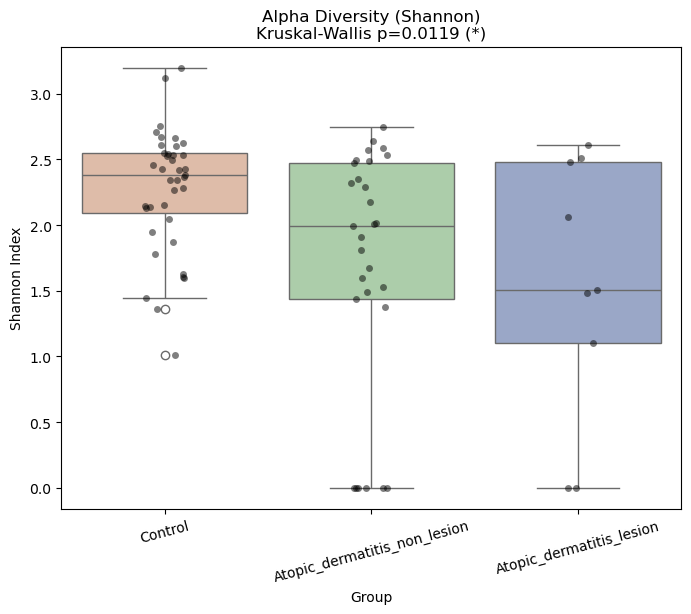

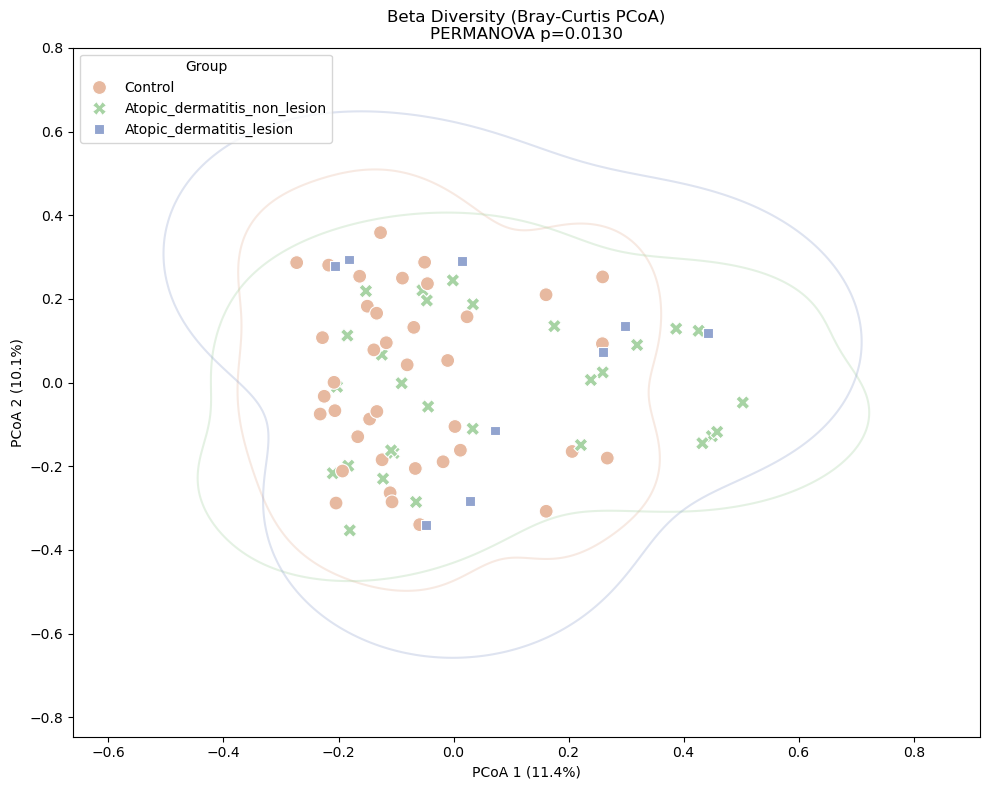

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy import stats  
import os
import itertools

# Tenta importar PCoA do scikit-bio para calcular a variância
try:
    from skbio.stats.ordination import pcoa
    HAS_SKBIO_PCOA = True
except ImportError:
    from sklearn.manifold import MDS
    HAS_SKBIO_PCOA = False

INPUT_FILE = "/home/marcos/PRJEB59406/results/Final_Table_Taxonomy_Function.tsv"
OUTPUT_DIR = "/home/marcos/PRJEB59406/figures/"
STATS_FILE = os.path.join(OUTPUT_DIR, "statistical_report.txt")

# Define the exact order for the plots
DESIRED_ORDER = ["Control", "Atopic_dermatitis_non_lesion", "Atopic_dermatitis_lesion"]

# Define as cores específicas para cada grupo
GROUP_COLORS = {
    "Control": "#e7b9a0",
    "Atopic_dermatitis_non_lesion": "#a7d3a4",
    "Atopic_dermatitis_lesion": "#92a4cf"
}

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Prepare statistics file
f_stats = open(STATS_FILE, 'w')
def log_stats(text):
    print(text)
    f_stats.write(text + "\n")

log_stats(f"--- STATISTICAL REPORT ---")
log_stats(f"Data Source: {INPUT_FILE}\n")

df = pd.read_csv(INPUT_FILE, sep='\t')

# Create readable labels
df['Label'] = df.apply(lambda x: x['Species'] if pd.notna(x['Species']) and len(str(x['Species'])) > 3 else f"{x['Genus']} ({x['mag_id']})", axis=1)

# Pivot: Rows=Samples, Cols=Bacteria, Values=Abundance
matrix = df.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)

# Map Samples to Groups
sample_to_group = df.drop_duplicates('Sample').set_index('Sample')['Group'].to_dict()
groups = matrix.index.map(sample_to_group)

# --- Logic to enforce your specific order ---
available_groups = set(groups.unique())
plot_order = [g for g in DESIRED_ORDER if g in available_groups]
plot_order.extend(sorted(list(available_groups - set(plot_order))))
log_stats(f"Groups found: {plot_order}")

log_stats("\n=== 1. ALPHA DIVERSITY (SHANNON) ===")

def calculate_shannon(row):
    """Calculates Shannon Entropy (Diversity)"""
    total = row.sum()
    if total == 0: return 0
    p = row / total
    p = p[p > 0] # Remove zeros
    return -np.sum(p * np.log(p))

alpha_df = pd.DataFrame(index=matrix.index)
alpha_df['Shannon'] = matrix.apply(calculate_shannon, axis=1)
alpha_df['Group'] = groups

# --- STATS: Kruskal-Wallis (Global) ---
groups_data = [alpha_df[alpha_df['Group'] == g]['Shannon'].values for g in plot_order]
h_stat, p_val_kw = stats.kruskal(*groups_data)
log_stats(f"Global Kruskal-Wallis Test: H={h_stat:.3f}, p-value={p_val_kw:.5f}")

significance_text = " (ns)"
if p_val_kw < 0.05:
    significance_text = " (*)" if p_val_kw < 0.01 else " (*)"
    log_stats("\n  -> Pairwise Comparisons (Mann-Whitney U):")
    for g1, g2 in itertools.combinations(plot_order, 2):
        d1 = alpha_df[alpha_df['Group'] == g1]['Shannon']
        d2 = alpha_df[alpha_df['Group'] == g2]['Shannon']
        u_stat, p_val_mw = stats.mannwhitneyu(d1, d2)
        log_stats(f"     {g1} vs {g2}: p={p_val_mw:.5f}")

# --- Plot Alpha ---
plt.figure(figsize=(8, 6))
sns.boxplot(data=alpha_df, x='Group', y='Shannon', order=plot_order, palette=GROUP_COLORS)
sns.stripplot(data=alpha_df, x='Group', y='Shannon', order=plot_order, color='black', alpha=0.5, jitter=True)

plt.title(f"Alpha Diversity (Shannon)\nKruskal-Wallis p={p_val_kw:.4f}{significance_text}")
plt.ylabel("Shannon Index")
plt.xticks(rotation=15)
filename_alpha = os.path.join(OUTPUT_DIR, "alpha_diversity_shannon.png")
plt.savefig(filename_alpha, dpi=300, bbox_inches='tight')
print(f"Alpha plot saved: {filename_alpha}")

log_stats("\n=== 2. BETA DIVERSITY (BRAY-CURTIS) ===")

# Calculate Bray-Curtis Dissimilarity
dist_matrix = pdist(matrix, metric='braycurtis')
dist_square = squareform(dist_matrix)

# --- STATS: PERMANOVA ---
permanova_title = ""
try:
    from skbio.stats.distance import permanova
    from skbio import DistanceMatrix
    
    dm = DistanceMatrix(dist_square, ids=matrix.index)
    perm_results = permanova(dm, groups, permutations=999)
    
    p_val_perm = perm_results['p-value']
    f_stat_perm = perm_results['test statistic']
    
    log_stats(f"PERMANOVA (999 perms): Pseudo-F={f_stat_perm:.3f}, p-value={p_val_perm:.4f}")
    permanova_title = f"\nPERMANOVA p={p_val_perm:.4f}"

except ImportError:
    log_stats("WARNING: 'scikit-bio' not installed. Skipping PERMANOVA.")
except Exception as e:
    log_stats(f"Could not run PERMANOVA: {e}")

# --- PCoA CALCULATION (With Variance Explained) ---
# Default labels if calculation fails
xlabel = "PCoA 1"
ylabel = "PCoA 2"

if HAS_SKBIO_PCOA:
    try:
        # Usa scikit-bio para calcular PCoA e Variância Explicada
        print("Calculating PCoA using scikit-bio...")
        pcoa_results = pcoa(dist_square)
        
        # Extrai coordenadas
        pcoa_df = pcoa_results.samples[['PC1', 'PC2']]
        pcoa_df.index = matrix.index
        
        # Extrai Variância Explicada (%)
        exp_var = pcoa_results.proportion_explained
        xlabel = f"PCoA 1 ({exp_var['PC1']:.1%})"
        ylabel = f"PCoA 2 ({exp_var['PC2']:.1%})"
        
        log_stats(f"Explained Variance: PC1={exp_var['PC1']:.1%}, PC2={exp_var['PC2']:.1%}")
        
    except Exception as e:
        print(f"Error in skbio PCoA: {e}. Falling back to MDS.")
        HAS_SKBIO_PCOA = False

if not HAS_SKBIO_PCOA:
    # Fallback para MDS (sem variância explicada)
    print("Using sklearn MDS (Variance explained not available).")
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
    pcoa_coords = mds.fit_transform(dist_square)
    pcoa_df = pd.DataFrame(pcoa_coords, columns=['PC1', 'PC2'], index=matrix.index)

# Add Groups to DataFrame
pcoa_df['Group'] = groups

# --- Plot Beta ---
plt.figure(figsize=(10, 8))

sns.scatterplot(data=pcoa_df, x='PC1', y='PC2', hue='Group', style='Group', 
                hue_order=plot_order, style_order=plot_order, 
                s=100, palette=GROUP_COLORS)

# Draw Density Ellipses
try:
    for group in plot_order:
        subset = pcoa_df[pcoa_df['Group'] == group]
        if len(subset) > 3:
            grp_color = GROUP_COLORS.get(group, 'grey')
            sns.kdeplot(x=subset['PC1'], y=subset['PC2'], levels=1, color=grp_color, alpha=0.3, warn_singular=False)
except:
    pass

plt.title(f"Beta Diversity (Bray-Curtis PCoA){permanova_title}")
# Aplica os labels dinâmicos com a porcentagem
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.legend(bbox_to_anchor=(0, 1), loc='upper left', title="Group")
plt.tight_layout()

filename_beta = os.path.join(OUTPUT_DIR, "beta_diversity_pcoa.png")
plt.savefig(filename_beta, dpi=300, bbox_inches='tight')
print(f"Beta plot saved: {filename_beta}")

# Close stats file
f_stats.close()
print(f"\n Full statistical report saved to: {STATS_FILE}")